# Análisis de la Telemetría de Baréin
Este notebook realiza un análisis de clustering sobre datos de setups recolectados el circuito de **Baréin**.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 📍 Paso 1: Preparación de los Datos - Circuito Internacional de Baréin

En este paso cargamos el dataset sanetizado del circuito de Baréin, eliminamos columnas irrelevantes (como `lapNumber` o identificadores), gestionamos valores nulos, y normalizamos los datos para su posterior análisis con técnicas de clustering.

Pasos específicos:
1. Cargar el dataset.
2. Eliminar columnas no necesarias para el clustering.
3. Filtrar vueltas inválidas (si `lapTime == 0`).
4. Normalizar las variables técnicas (`StandardScaler`).

In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Cargar datos del circuito de Baréin
df_bahrein = pd.read_csv("/content/drive/MyDrive/Telemetria-F1-24/bahrein_sanitized.csv")

# Vista previa de las primeras columnas
print("Columnas iniciales:", df_bahrein.columns.tolist())
df_bahrein.head()

Columnas iniciales: ['lapTimeInMS', 'm_frontWing', 'm_rearWing', 'm_onThrottle', 'm_offThrottle', 'm_frontCamber', 'm_rearCamber', 'm_frontToe', 'm_rearToe', 'm_frontSuspension', 'm_rearSuspension', 'm_frontAntiRollBar', 'm_rearAntiRollBar', 'm_frontSuspensionHeight', 'm_rearSuspensionHeight', 'm_brakePressure', 'm_brakeBias', 'm_engineBraking', 'm_rearLeftTyrePressure', 'm_rearRightTyrePressure', 'm_frontLeftTyrePressure', 'm_frontRightTyrePressure', 'm_ballast', 'm_fuelLoad', 'circuit']


,lapTimeInMS,m_frontWing,m_rearWing,m_onThrottle,m_offThrottle,m_frontCamber,m_rearCamber,m_frontToe,m_rearToe,m_frontSuspension,...,m_brakePressure,m_brakeBias,m_engineBraking,m_rearLeftTyrePressure,m_rearRightTyrePressure,m_frontLeftTyrePressure,m_frontRightTyrePressure,m_ballast,m_fuelLoad,circuit
0,90260,44,41,70,50,-3.5,-2.2,0.0,0.0,38,...,100,54,80,26.5,26.5,29.5,29.5,6,10.0,bahrein
1,89600,44,41,70,50,-3.5,-2.2,0.0,0.0,38,...,100,54,80,26.5,26.5,29.5,29.5,6,10.0,bahrein
2,89998,44,41,70,50,-3.5,-2.2,0.0,0.0,38,...,100,54,80,26.5,26.5,29.5,29.5,6,10.0,bahrein
3,90294,44,41,70,50,-3.5,-2.2,0.0,0.0,38,...,100,54,80,26.5,26.5,29.5,29.5,6,10.0,bahrein
4,90101,44,41,70,50,-3.5,-2.2,0.0,0.0,38,...,100,54,80,26.5,26.5,29.5,29.5,6,10.0,bahrein


In [3]:
# Filtrar filas con tiempo de vuelta válido
df_bahrein = df_bahrein[df_bahrein["lapTimeInMS"] > 0]

# Eliminar columnas irrelevantes
columns_to_drop = ['lapNumber', 'circuit', 'm_ballast', 'm_fuelLoad']
df_bahrein = df_bahrein.drop(columns=columns_to_drop, errors='ignore')

# Eliminar columnas completamente vacías
df_bahrein = df_bahrein.dropna(axis=1, how='all')

# Eliminar filas con valores nulos
df_bahrein = df_bahrein.dropna()

# Eliminar vueltas duplicadas (setup + tiempo idéntico)
df_bahrein = df_bahrein.drop_duplicates()

# Separar tiempos por vuelta y entradas
lap_times = df_bahrein["lapTimeInMS"]
X_raw = df_bahrein.drop(columns=["lapTimeInMS"])

print(f"Dataset limpio. Dimensiones finales: {X_raw.shape}")
X_raw.head()

Dataset limpio. Dimensiones finales: (121, 21)


,m_frontWing,m_rearWing,m_onThrottle,m_offThrottle,m_frontCamber,m_rearCamber,m_frontToe,m_rearToe,m_frontSuspension,m_rearSuspension,...,m_rearAntiRollBar,m_frontSuspensionHeight,m_rearSuspensionHeight,m_brakePressure,m_brakeBias,m_engineBraking,m_rearLeftTyrePressure,m_rearRightTyrePressure,m_frontLeftTyrePressure,m_frontRightTyrePressure
0,44,41,70,50,-3.5,-2.2,0.0,0.0,38,3,...,11,22,58,100,54,80,26.5,26.5,29.5,29.5
1,44,41,70,50,-3.5,-2.2,0.0,0.0,38,3,...,11,22,58,100,54,80,26.5,26.5,29.5,29.5
2,44,41,70,50,-3.5,-2.2,0.0,0.0,38,3,...,11,22,58,100,54,80,26.5,26.5,29.5,29.5
3,44,41,70,50,-3.5,-2.2,0.0,0.0,38,3,...,11,22,58,100,54,80,26.5,26.5,29.5,29.5
4,44,41,70,50,-3.5,-2.2,0.0,0.0,38,3,...,11,22,58,100,54,80,26.5,26.5,29.5,29.5


In [4]:
from sklearn.preprocessing import StandardScaler

# Normalizar
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

print(f"Dataset limpio y normalizado. Dimensiones finales: {X_scaled.shape}")
X_scaled[:5]

Dataset limpio y normalizado. Dimensiones finales: (121, 21)


array([[ 0.72563843,  0.80147827,  0.34059647, -0.45470152, -0.47140452,
        -0.46252622, -1.09921046, -1.38023432,  0.02756008, -0.45679431,
        -0.53948557, -0.55874241,  0.21842601,  0.02219929,  0.5752296 ,
        -0.4458938 , -0.03818018,  1.06817117,  1.06817117,  1.19199723,
         1.19476579],
       [ 0.72563843,  0.80147827,  0.34059647, -0.45470152, -0.47140452,
        -0.46252622, -1.09921046, -1.38023432,  0.02756008, -0.45679431,
        -0.53948557, -0.55874241,  0.21842601,  0.02219929,  0.5752296 ,
        -0.4458938 , -0.03818018,  1.06817117,  1.06817117,  1.19199723,
         1.19476579],
       [ 0.72563843,  0.80147827,  0.34059647, -0.45470152, -0.47140452,
        -0.46252622, -1.09921046, -1.38023432,  0.02756008, -0.45679431,
        -0.53948557, -0.55874241,  0.21842601,  0.02219929,  0.5752296 ,
        -0.4458938 , -0.03818018,  1.06817117,  1.06817117,  1.19199723,
         1.19476579],
       [ 0.72563843,  0.80147827,  0.34059647, -0.45470152

# ✳️ Paso 2: Reducción de Dimensionalidad

Para visualizar la distribución de los setups en el espacio latente, aplicaremos:

1. **PCA (Análisis de Componentes Principales)** para una reducción lineal.
2. **t-SNE (t-Distributed Stochastic Neighbor Embedding)** para una reducción no lineal, ideal para detectar estructuras complejas.

Ambos métodos nos ayudarán a inspeccionar visualmente si existe alguna agrupación natural entre los setups.

## Visualización con PCA


Cálculo de la varianza por componente. Seleccionamos aquel número de componentes que supere el umbral del 80% ya que nos indica que no supondrá una gran pérdida de información.

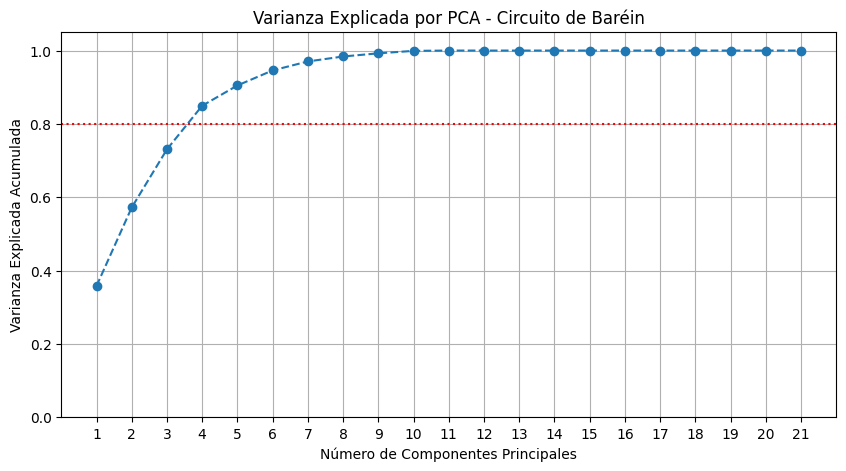

In [5]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Ajustar PCA conservando todos los componentes
pca_full = PCA()
pca_full.fit(X_scaled)

# Varianza explicada por componente
explained_var = pca_full.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)

# Gráfico de varianza explicada
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(explained_var) + 1), cumulative_var, marker='o', linestyle='--')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Varianza Explicada Acumulada')
plt.title('Varianza Explicada por PCA - Circuito de Baréin')
plt.grid(True)
plt.xticks(range(1, len(explained_var) + 1))
plt.ylim(0, 1.05)
plt.axhline(y=0.8, color='r', linestyle=':')  # umbral típico del 80%
plt.show()

Gráfico con los cuatro componentes.

In [6]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Aplicar PCA con 4 componentes
pca = PCA(n_components=4)
X_pca = pca.fit_transform(X_scaled)


In [7]:
import plotly.express as px

# Visualización con 3 dimensiones + PC4 por color
df_plotly = pd.DataFrame(X_pca, columns=["PC1", "PC2", "PC3", "PC4"])
fig = px.scatter_3d(df_plotly, x="PC1", y="PC2", z="PC3",
                    color="PC4", color_continuous_scale="Viridis",
                    title="PCA 3D (Color por PC4) - Circuito de Baréin")
fig.show()

In [8]:
# Visualización con 3 dimensiones + PC4 por color
df_plotly = pd.DataFrame(X_pca, columns=["PC1", "PC2", "PC3", "PC4"])
df_plotly["lapTime"] = lap_times.values
fig = px.scatter_3d(df_plotly, x="PC1", y="PC2", z="PC3",
                    color="lapTime", color_continuous_scale="Viridis",
                    title="PCA 3D (Color por lapTime) - Circuito de Baréin",
                    labels={"lapTime": "lapTime (ms)"})
fig.show()

Visualizamos todas las combinaciones posibles entre 4 componentes (PC1 vs PC2, PC1 vs PC3, etc.).

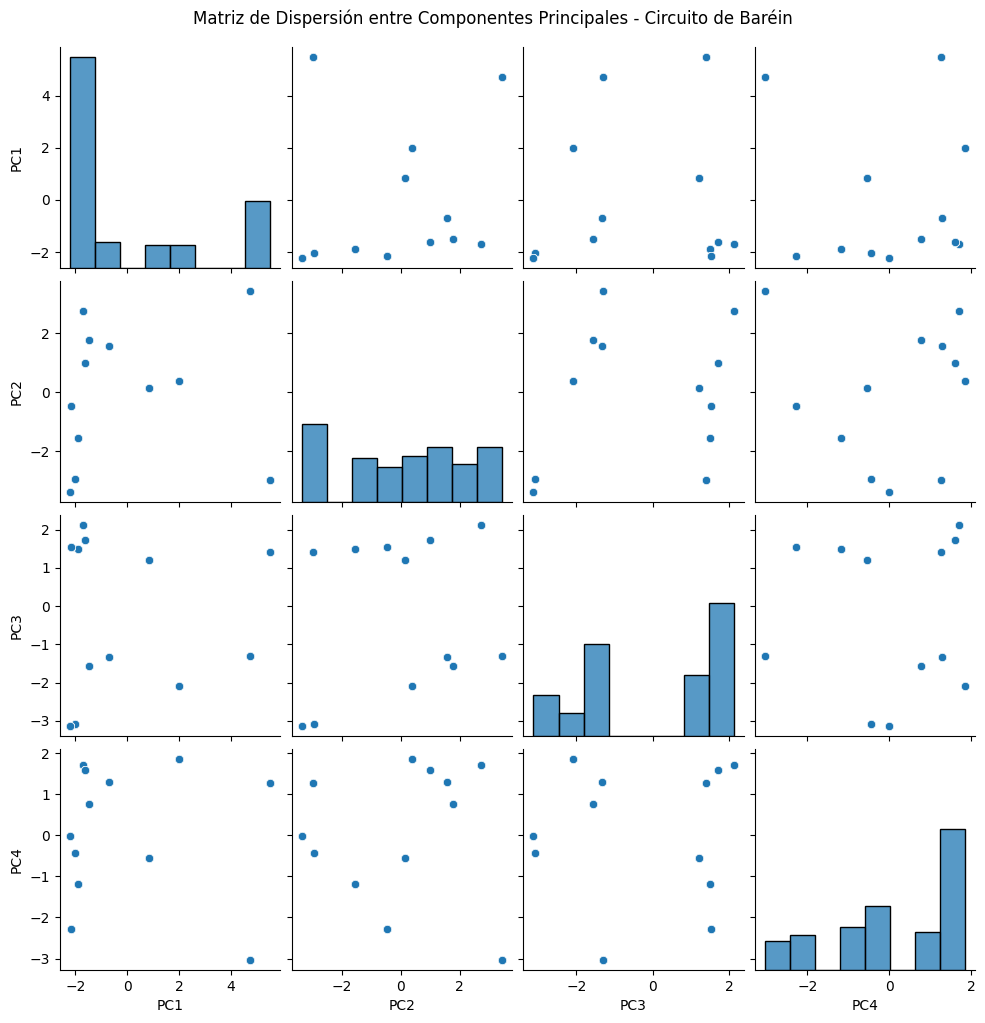

In [9]:
import pandas as pd
import seaborn as sns

df_pca = pd.DataFrame(X_pca, columns=["PC1", "PC2", "PC3", "PC4"])
sns.pairplot(df_pca)
plt.suptitle("Matriz de Dispersión entre Componentes Principales - Circuito de Baréin", y=1.02)
plt.show()

Gráfico de barras con la contribución de cada variable para cada uno de los dos componentes.

,PC1,PC2,PC3,PC4
m_rearSuspension,0.334775,-0.084026,0.102280,-0.019641
m_rearCamber,0.310786,0.071557,-0.020016,-0.222184
m_frontCamber,0.185285,-0.117068,0.040871,0.240945
m_rearSuspensionHeight,0.162482,0.117615,-0.189342,-0.431705
m_brakeBias,0.136247,0.315624,0.027168,-0.316053
m_rearToe,0.110671,0.431910,-0.048256,0.014920
m_frontSuspensionHeight,0.103641,-0.232641,0.318642,-0.171222
m_offThrottle,0.073871,0.411612,0.057756,0.167401
m_frontToe,-0.009172,0.283658,-0.026501,0.492653
m_brakePressure,-0.059860,-0.041491,-0.305933,-0.351404


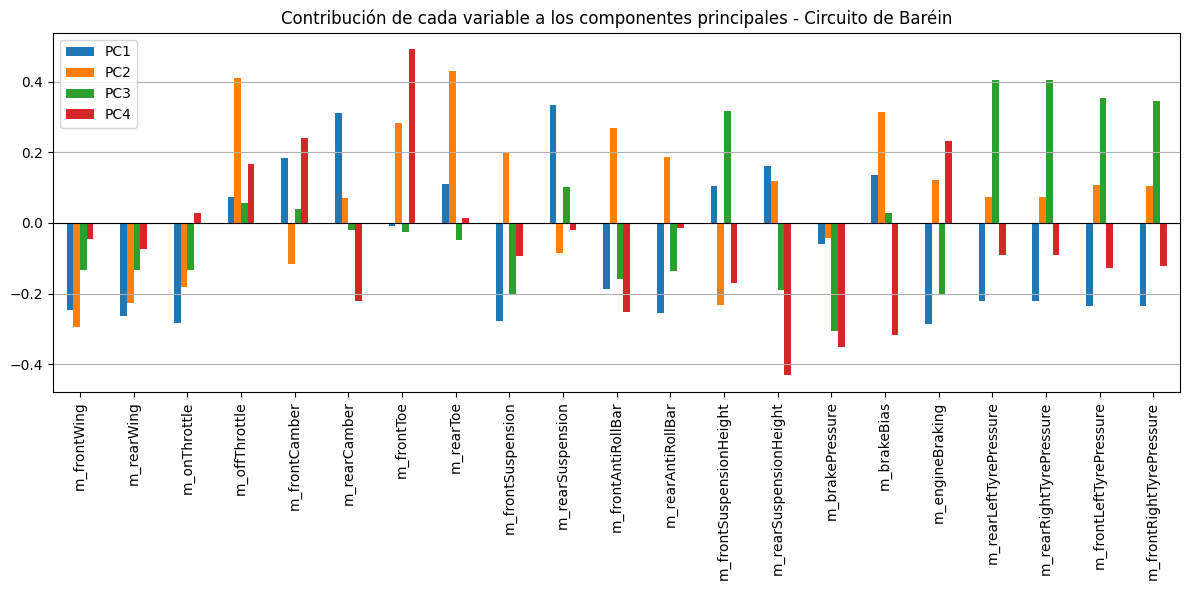

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar los nombres de las variables originales
feature_names = X_raw.columns

# Obtener los loadings (coeficientes de cada variable en cada componente)
loadings = pd.DataFrame(pca.components_.T, index=feature_names,
                        columns=['PC1', 'PC2', 'PC3', 'PC4'])

# Mostrar en tabla ordenada por importancia en PC1
display(loadings.sort_values(by='PC1', ascending=False))

# Visualización en gráfico de barras
loadings.plot(kind='bar', figsize=(12, 6))
plt.title("Contribución de cada variable a los componentes principales - Circuito de Baréin")
plt.axhline(0, color='black', linewidth=0.8)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

Top 5 contribuciones positivas/negativas por cada uno de los dos componentes.

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Función para mostrar top 5 positivos y negativos de cada componente
def show_top_contributors(loadings, n=5):
    for pc in loadings.columns:
        print(f"\nTop {n} contribuciones positivas en {pc}:")
        print(loadings[pc].sort_values(ascending=False).head(n))

        print(f"\nTop {n} contribuciones negativas en {pc}:")
        print(loadings[pc].sort_values(ascending=True).head(n))

        # Visualización en gráfico de barras
        top_pos = loadings[pc].sort_values(ascending=False).head(n)
        top_neg = loadings[pc].sort_values().head(n)
        top_combined = pd.concat([top_pos, top_neg])

        plt.figure(figsize=(10, 5))
        top_combined.plot(kind='bar',
                          color=['green' if v > 0 else 'red' for v in top_combined])
        plt.title(f'Top {n} contribuciones en {pc} - Circuito de Baréin')
        plt.axhline(0, color='black', linewidth=0.8)
        plt.ylabel("Peso en el componente")
        plt.xticks(rotation=45, ha='right')
        plt.grid(True, axis='y')
        plt.tight_layout()
        plt.show()


Top 5 contribuciones positivas en PC1:
m_rearSuspension          0.334775
m_rearCamber              0.310786
m_frontCamber             0.185285
m_rearSuspensionHeight    0.162482
m_brakeBias               0.136247
Name: PC1, dtype: float64

Top 5 contribuciones negativas en PC1:
m_engineBraking     -0.286572
m_onThrottle        -0.284033
m_frontSuspension   -0.278284
m_rearWing          -0.263425
m_rearAntiRollBar   -0.256019
Name: PC1, dtype: float64


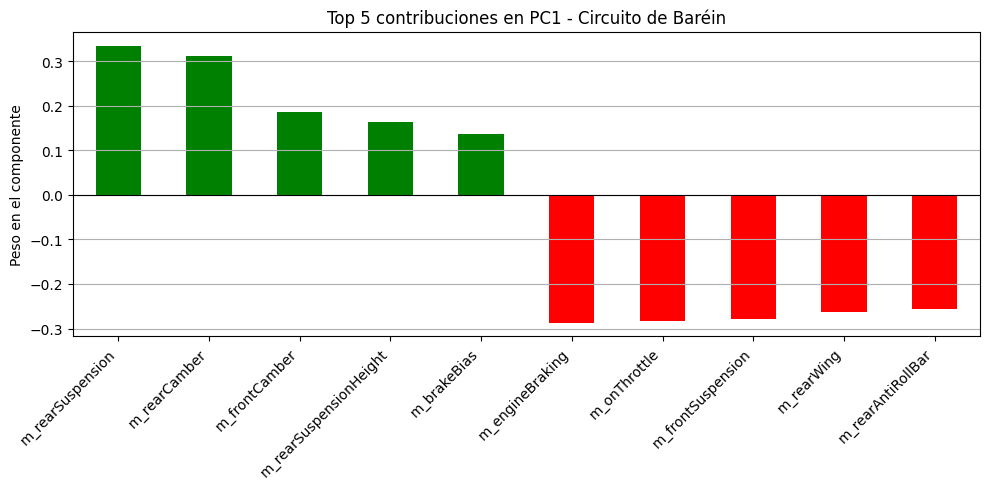


Top 5 contribuciones positivas en PC2:
m_rearToe             0.431910
m_offThrottle         0.411612
m_brakeBias           0.315624
m_frontToe            0.283658
m_frontAntiRollBar    0.268803
Name: PC2, dtype: float64

Top 5 contribuciones negativas en PC2:
m_frontWing               -0.294202
m_frontSuspensionHeight   -0.232641
m_rearWing                -0.227252
m_onThrottle              -0.182303
m_frontCamber             -0.117068
Name: PC2, dtype: float64


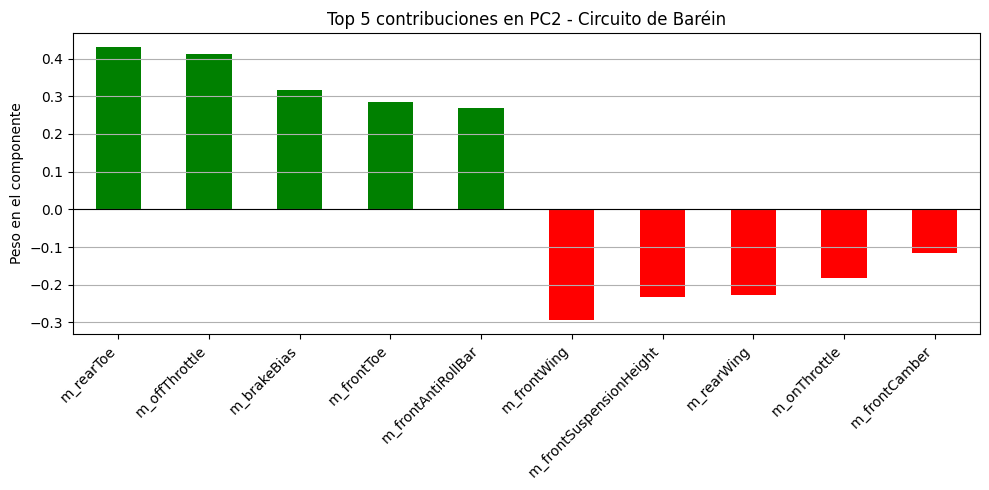


Top 5 contribuciones positivas en PC3:
m_rearLeftTyrePressure      0.404481
m_rearRightTyrePressure     0.404481
m_frontLeftTyrePressure     0.353539
m_frontRightTyrePressure    0.345910
m_frontSuspensionHeight     0.318642
Name: PC3, dtype: float64

Top 5 contribuciones negativas en PC3:
m_brakePressure          -0.305933
m_engineBraking          -0.200618
m_frontSuspension        -0.200044
m_rearSuspensionHeight   -0.189342
m_frontAntiRollBar       -0.159526
Name: PC3, dtype: float64


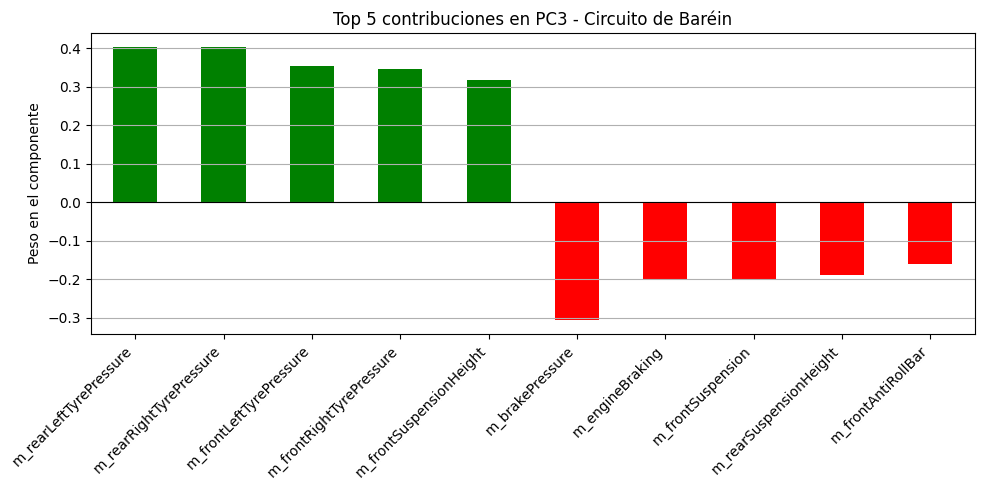


Top 5 contribuciones positivas en PC4:
m_frontToe         0.492653
m_frontCamber      0.240945
m_engineBraking    0.232417
m_offThrottle      0.167401
m_onThrottle       0.028084
Name: PC4, dtype: float64

Top 5 contribuciones negativas en PC4:
m_rearSuspensionHeight   -0.431705
m_brakePressure          -0.351404
m_brakeBias              -0.316053
m_frontAntiRollBar       -0.252734
m_rearCamber             -0.222184
Name: PC4, dtype: float64


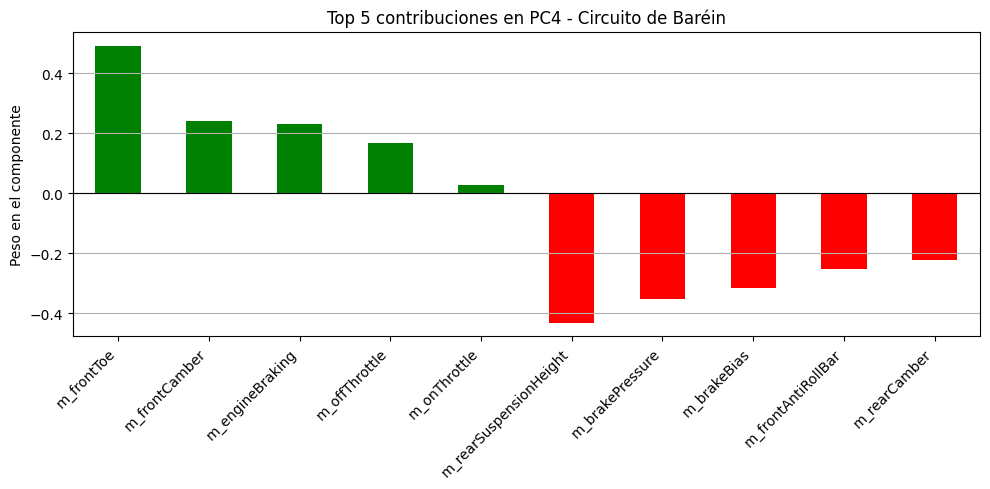

In [12]:
show_top_contributors(loadings, n=5)

Correlación entre cada uno de los componentes y el tiempo por vuelta.

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

def analyze_pca_vs_lap_time(X_pca, lap_times):
    """
    Analiza la relación entre cada componente principal y el tiempo por vuelta.

    Parámetros:
    - X_pca: array de shape (n_samples, n_components) obtenido de PCA.
    - lap_times: array de tiempos por vuelta (n_samples,).

    Salida:
    - Gráficos de dispersión.
    - Correlaciones de Pearson.
    - Coeficientes de determinación R² para cada componente.
    """
    n_components = X_pca.shape[1]

    for i in range(n_components):
        pc = X_pca[:, i]
        corr = np.corrcoef(pc, lap_times)[0, 1]

        # Regresión lineal simple
        reg = LinearRegression().fit(pc.reshape(-1, 1), lap_times)
        r2 = r2_score(lap_times, reg.predict(pc.reshape(-1, 1)))

        # Gráfico
        plt.figure(figsize=(8, 5))
        sns.scatterplot(x=pc, y=lap_times)
        plt.xlabel(f'PC{i+1}')
        plt.ylabel('Tiempo por vuelta')
        plt.title(f'Relación entre PC{i+1} y el tiempo por vuelta - Circuito de Baréin\nCorrelación = {corr:.3f}, R² = {r2:.3f}')
        plt.grid(True)
        plt.show()

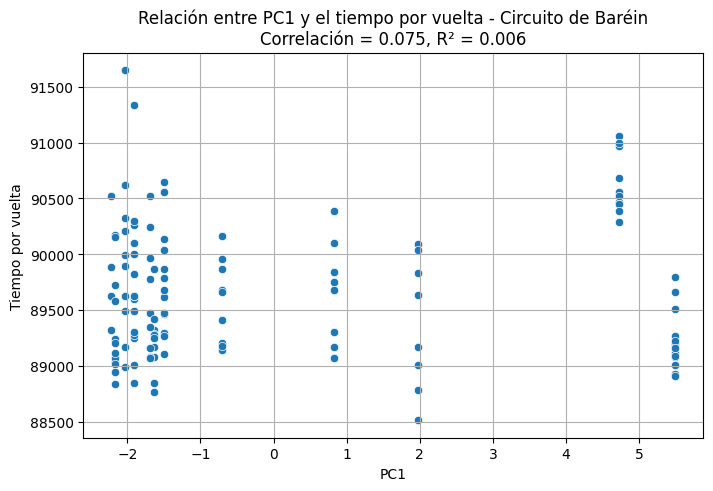

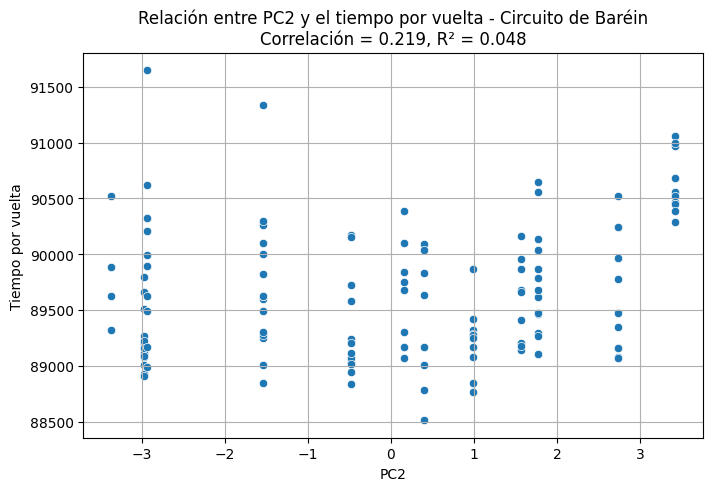

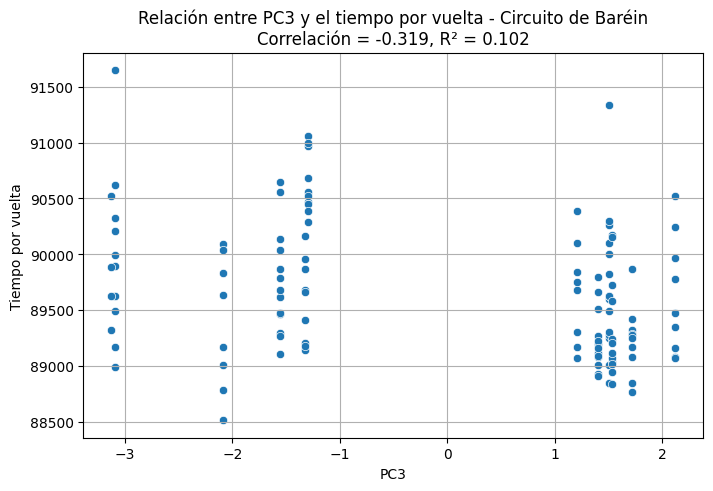

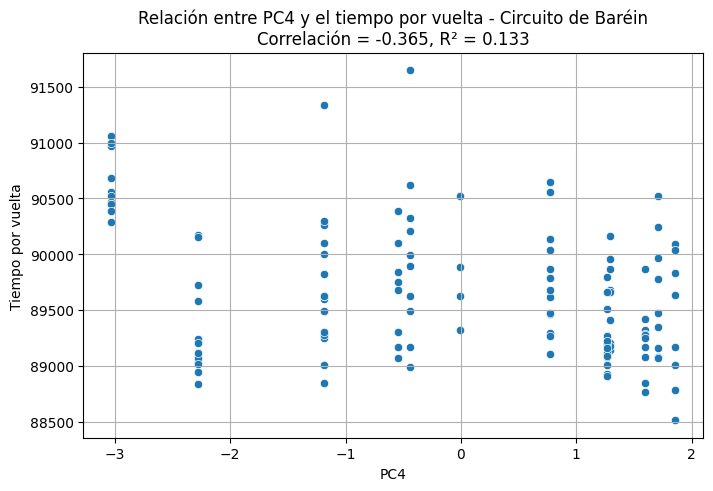

In [14]:
analyze_pca_vs_lap_time(X_pca, lap_times)

## Visualización con t-SNE

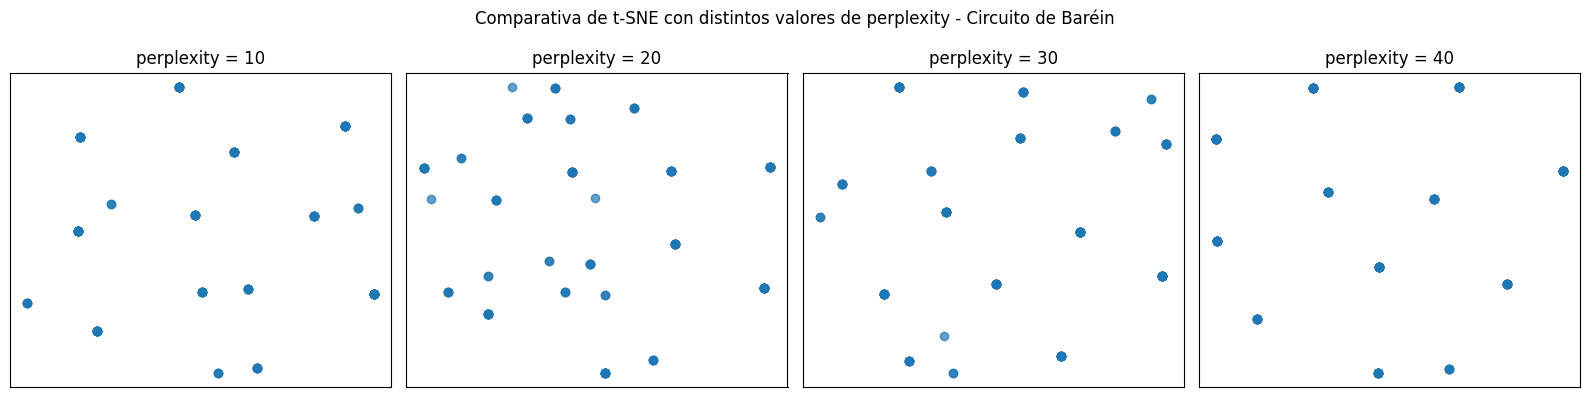

In [15]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Valores de perplexity a probar
perplexities = [10, 20, 30, 40]

fig, axs = plt.subplots(1, len(perplexities), figsize=(16, 4))
fig.suptitle("Comparativa de t-SNE con distintos valores de perplexity - Circuito de Baréin")

for i, perp in enumerate(perplexities):
    tsne = TSNE(n_components=2, perplexity=perp, max_iter=600, random_state=42)
    X_tsne = tsne.fit_transform(X_scaled)

    axs[i].scatter(X_tsne[:, 0], X_tsne[:, 1], alpha=0.7)
    axs[i].set_title(f"perplexity = {perp}")
    axs[i].set_xticks([])
    axs[i].set_yticks([])

plt.tight_layout()
plt.show()

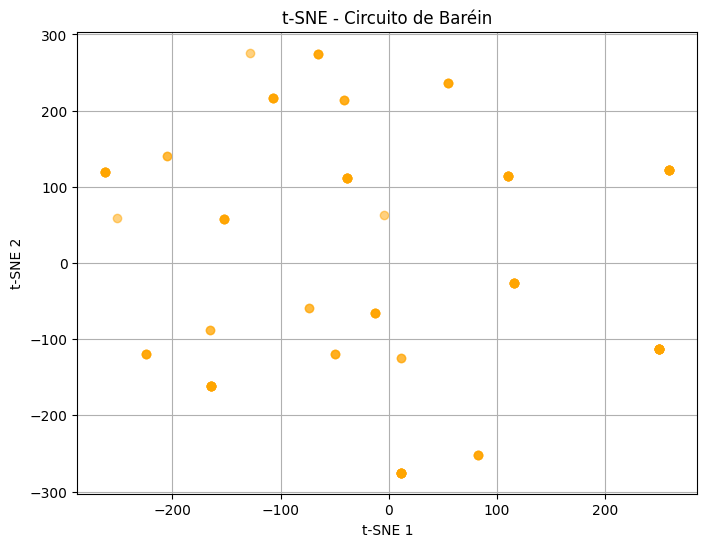

In [16]:
from sklearn.manifold import TSNE

# Aplicar t-SNE
tsne = TSNE(n_components=2, perplexity=20, max_iter=600, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# Visualización t-SNE
plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c='orange', alpha=0.5)
plt.title("t-SNE - Circuito de Baréin")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.grid(True)
plt.show()

# 🧩 Paso 3: Clustering con K-Means + Silhouette Score

En este paso buscamos identificar agrupaciones naturales (clusters) en los setups del circuito de Baréin usando K-Means.

Pasos:
1. Calcular el Silhouette Score para valores de K entre 2 y 12 (número de reglajes distintos).
2. Elegir el mejor K.
3. Visualizar los clusters con las proyecciones obtenidas por PCA y t-SNE.

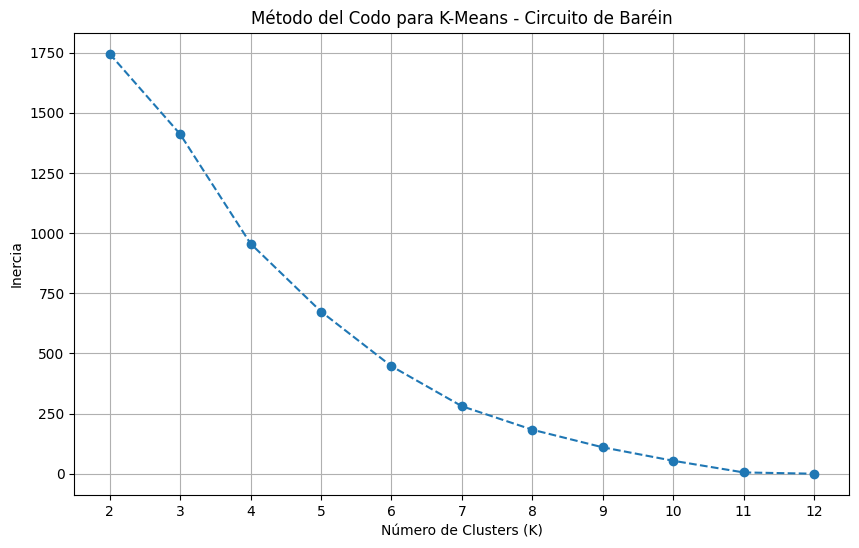

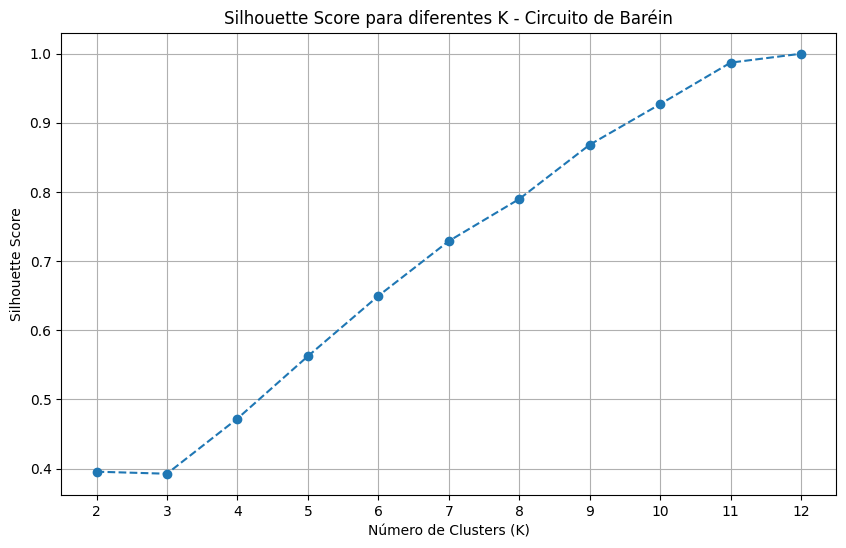

Silhouette Scores: [np.float64(0.39551854465444225), np.float64(0.3925849096842183), np.float64(0.47232184858273374), np.float64(0.5625239405298251), np.float64(0.6497209565076334), np.float64(0.7290290986625625), np.float64(0.7898539045318866), np.float64(0.8683760859842931), np.float64(0.9270730367501542), np.float64(0.9871041837832524), np.float64(0.9999999929201878)]
Inertia Scores: [1745.8860152502875, 1411.8147807461964, 956.5809993383837, 674.1364769068525, 446.9207620253418, 280.5469108565395, 182.90537106287198, 109.7043842848161, 53.813444475042346, 5.330542028853591, 8.50799895568099e-29]


In [17]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Rango de K a probar (de 2 a 12 porque tenemos 12 reglajes como máximo)
k_range = range(2, 13)
silhouette_scores = []
inertia_scores = [] # Para el método del codo

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10) # Añadir n_init
    kmeans.fit(X_scaled)

    # Calcular Silhouette Score
    score = silhouette_score(X_scaled, kmeans.labels_)
    silhouette_scores.append(score)

    # Guardar inercia para el método del codo
    inertia_scores.append(kmeans.inertia_)

# Gráfico del método del codo (Inercia)
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia_scores, marker='o', linestyle='--')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Inercia')
plt.title('Método del Codo para K-Means - Circuito de Baréin')
plt.xticks(k_range)
plt.grid(True)
plt.show()

# Gráfico de Silhouette Score
plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores, marker='o', linestyle='--')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score para diferentes K - Circuito de Baréin')
plt.xticks(k_range)
plt.grid(True)
plt.show()

# Mostrar los scores para ver numéricamente
print("Silhouette Scores:", silhouette_scores)
print("Inertia Scores:", inertia_scores)

In [18]:
# Elegimos el K donde hay una granularidad moderada y que no hace un sobreajuste
# Entrenamos modelo final
best_k = 7
kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init="auto")
cluster_labels = kmeans_final.fit_predict(X_scaled)

## Visualización con PCA

In [19]:
# Crear DataFrame para visualización
df_pca = pd.DataFrame(X_pca, columns=["PC1", "PC2", "PC3", "PC4"])
df_pca["cluster"] = cluster_labels
df_pca["lapTimeInMS"] = lap_times.values

# Gráfico 3D interactivo
fig = px.scatter_3d(df_pca, x="PC1", y="PC2", z="PC3",
                    color="cluster",  # Colorea por etiqueta de cluster
                    hover_data=["lapTimeInMS"],  # mostrar tiempo en hover
                    title="Clusters con K-Means (PCA 3D) - Circuito de Baréin")

fig.update_layout(scene=dict(
    xaxis_title="Componente principal 1",
    yaxis_title="Componente principal 2",
    zaxis_title="Componente principal 3"
))

fig.show()

## Visualización con t-SNE

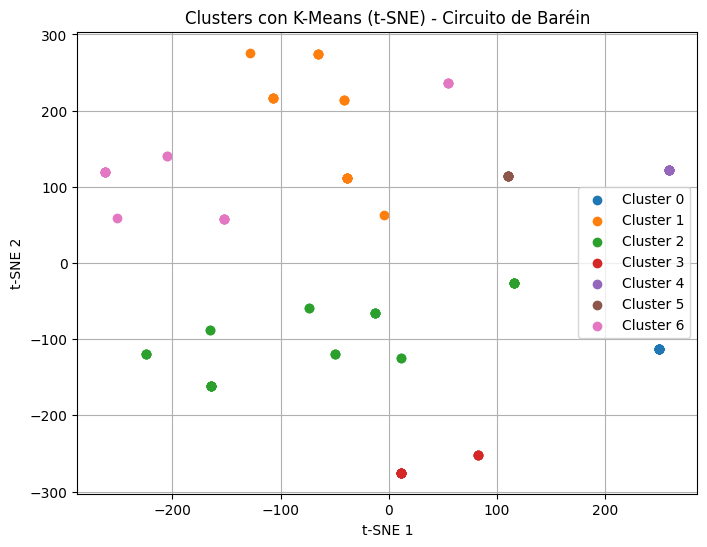

In [20]:
plt.figure(figsize=(8, 6))
for i in range(best_k):
    plt.scatter(X_tsne[cluster_labels == i, 0], X_tsne[cluster_labels == i, 1], label=f'Cluster {i}')
plt.title("Clusters con K-Means (t-SNE) - Circuito de Baréin")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend()
plt.grid(True)
plt.show()

## Cálculo de centroides con K-means

In [21]:
import pandas as pd

# Reconstruir los setups escalados a su forma original
X_unscaled = pd.DataFrame(scaler.inverse_transform(X_scaled), columns=X_raw.columns)

# Añadir etiquetas de clúster y tiempo de vuelta original
X_unscaled["cluster"] = cluster_labels
X_unscaled["lapTime"] = lap_times.values

# Agrupar por clúster y calcular centroides (media de setups) y tiempo medio
centroids_df = X_unscaled.groupby("cluster").mean().reset_index()

# Ordenar por tiempo medio de vuelta (opcional, para interpretación posterior)
centroids_df = centroids_df.sort_values(by="lapTime").reset_index(drop=True)

centroids_df.head()

,cluster,m_frontWing,m_rearWing,m_onThrottle,m_offThrottle,m_frontCamber,m_rearCamber,m_frontToe,m_rearToe,m_frontSuspension,...,m_frontSuspensionHeight,m_rearSuspensionHeight,m_brakePressure,m_brakeBias,m_engineBraking,m_rearLeftTyrePressure,m_rearRightTyrePressure,m_frontLeftTyrePressure,m_frontRightTyrePressure,lapTime
0,0,34.000000,30.000000,40.000000,50.000000,-3.200000,-1.8,0.090000,0.080000,23.000000,...,25.000000,55.000000,97.000000,54.000000,30.000000,21.0,21.0,23.400000,23.400000,89225.307692
1,5,38.000000,25.000000,55.000000,60.000000,-3.500000,-2.2,0.250000,0.250000,41.000000,...,20.000000,55.000000,100.000000,55.000000,100.000000,20.5,20.5,22.500000,22.500000,89383.625000
2,6,35.263158,32.105263,67.894737,65.000000,-3.500000,-2.2,0.250000,0.250000,39.421053,...,20.000000,52.631579,96.052632,53.947368,100.000000,26.5,26.5,29.500000,29.500000,89417.842105
3,2,42.514286,37.228571,64.857143,49.428571,-3.500000,-2.2,0.022857,0.097143,38.800000,...,23.485714,56.971429,100.000000,54.914286,74.285714,26.5,26.5,28.471429,28.357143,89578.514286
4,1,39.636364,38.818182,63.636364,70.000000,-3.377273,-2.2,0.250000,0.250000,41.000000,...,20.000000,55.000000,100.000000,55.000000,100.000000,23.0,23.0,26.000000,26.000000,89691.272727


## Exportado de centroides con K-means

In [22]:
# Exportamos los centroides para usarlos en el sistema recomendador
centroids_df.to_csv("bahrein_kmeans_centroids.csv", index=False)
print("Centroides exportados correctamente a 'bahrein_kmeans_centroids.csv'")

Centroides exportados correctamente a 'bahrein_kmeans_centroids.csv'


# ⚙️ Paso 4: Clustering con DBSCAN

Utilizaremos el algoritmo DBSCAN para encontrar agrupaciones sin necesidad de definir el número de clusters.

Pasos:
1. Ajustar el modelo DBSCAN sobre los datos normalizados.
2. Visualizar los clusters con PCA y t-SNE.
3. Calcular los centroides descartando el ruido (`cluster = -1`).
4. Exportar los centroides para el sistema recomendador.

Agrupamos reglajes únicos y persistimos el tiempo más rápido.

In [23]:
# Unir X_raw y lap_times en un único DataFrame
df_full = X_raw.copy()
df_full["lapTime"] = lap_times.values

# Agrupar por combinaciones únicas de reglajes y calcular la media de tiempos
df_grouped = df_full.groupby(list(X_raw.columns)).agg({
    "lapTime": "min"
}).reset_index()

Estandarizamos reglajes únicos.

In [24]:
from sklearn.preprocessing import StandardScaler

X_unique = df_grouped.drop(columns=["lapTime"])
y_unique = df_grouped["lapTime"]

scaler = StandardScaler()
X_scaled_unique = scaler.fit_transform(X_unique)

Determinamos eps con curva k-distance.

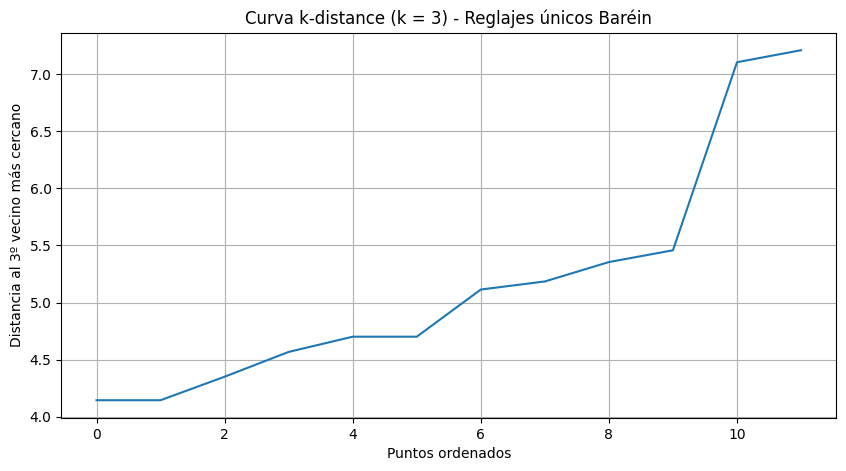

In [25]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np

min_samples = 3  # ajustar de 3 a 5
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(X_scaled_unique)
distances, indices = neighbors_fit.kneighbors(X_scaled_unique)
k_distances = np.sort(distances[:, -1])

plt.figure(figsize=(10, 5))
plt.plot(k_distances)
plt.title(f'Curva k-distance (k = {min_samples}) - Reglajes únicos Baréin')
plt.xlabel('Puntos ordenados')
plt.ylabel(f'Distancia al {min_samples}º vecino más cercano')
plt.grid(True)
plt.show()


Aplicamos DBSCAN sobre los datos únicos.

In [26]:
from sklearn.cluster import DBSCAN
import numpy as np

from sklearn.cluster import DBSCAN

# Estimar eps visualmente desde la curva anterior
eps = 5.5  # lo ajustamos en función de la gráfica
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
db_labels = dbscan.fit_predict(X_scaled_unique)

# Añadir los resultados al DataFrame agrupado
df_grouped["cluster"] = db_labels

# Contar etiquetas encontradas
n_clusters_db = len(set(db_labels)) - (1 if -1 in db_labels else 0)
n_noise = list(db_labels).count(-1)
print(f"🔍 DBSCAN encontró {n_clusters_db} clusters y {n_noise} puntos de ruido.")

🔍 DBSCAN encontró 1 clusters y 2 puntos de ruido.


## Visualización con PCA

In [27]:
from sklearn.decomposition import PCA
import plotly.express as px

X_pca_dbscan = pca.fit_transform(X_scaled_unique)

df_grouped[["PC1", "PC2", "PC3", "PC4"]] = X_pca_dbscan

fig = px.scatter_3d(df_grouped, x="PC1", y="PC2", z="PC3",
                    color="cluster",
                    hover_data=["lapTime"],
                    title="Clusters DBSCAN (PCA 3D) - Circuito de Baréin")
fig.show()

## Visualización con t-SNE

In [28]:
tsne = TSNE(n_components=2, perplexity=2, max_iter=1000, random_state=42)
X_tsne_dbscan = tsne.fit_transform(X_scaled_unique)

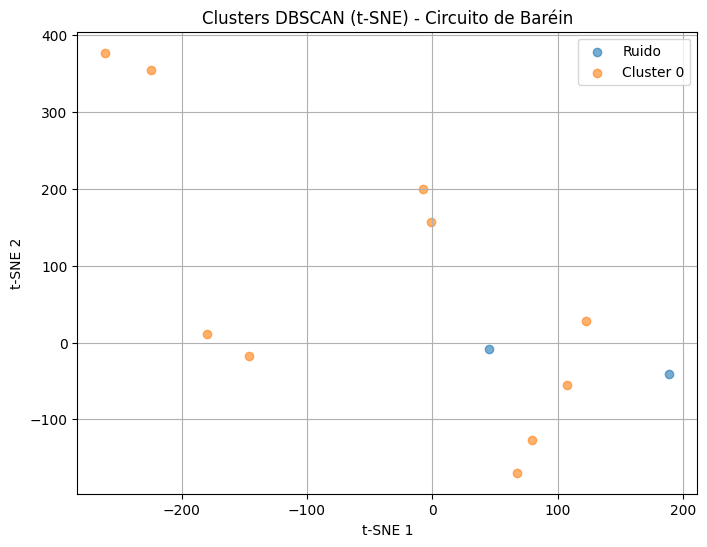

In [29]:
plt.figure(figsize=(8, 6))
unique_labels = np.unique(db_labels)
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))

for k, col in zip(unique_labels, colors):
    class_member_mask = (db_labels == k)
    label = "Ruido" if k == -1 else f"Cluster {k}"
    plt.scatter(X_tsne_dbscan[class_member_mask, 0], X_tsne_dbscan[class_member_mask, 1],
                label=label, alpha=0.6)

plt.title("Clusters DBSCAN (t-SNE) - Circuito de Baréin")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend()
plt.grid(True)
plt.show()

## Cálculo de centroides (sin ruido)

In [30]:
# Reconstrucción de los reglajes originales desde los datos únicos
X_db_unscaled = pd.DataFrame(scaler.inverse_transform(X_scaled_unique),
                             columns=X_raw.columns)  # usar las columnas originales de reglajes

# Añadir etiquetas de cluster y tiempos mínimos
X_db_unscaled["cluster"] = db_labels  # obtenidos de DBSCAN
X_db_unscaled["lapTime"] = y_unique.values  # mejores tiempos por reglaje

# Filtrar los puntos que no son ruido
X_db_filtered = X_db_unscaled[X_db_unscaled["cluster"] != -1]

# Calcular centroides de cada cluster y tiempo medio por vuelta
db_centroids_df = X_db_filtered.groupby("cluster").mean().reset_index()

# Ordenar por tiempo medio (el más bajo primero)
db_centroids_df = db_centroids_df.sort_values(by="lapTime").reset_index(drop=True)

# Mostrar primeros centroides
db_centroids_df.head()

,cluster,m_frontWing,m_rearWing,m_onThrottle,m_offThrottle,m_frontCamber,m_rearCamber,m_frontToe,m_rearToe,m_frontSuspension,...,m_frontSuspensionHeight,m_rearSuspensionHeight,m_brakePressure,m_brakeBias,m_engineBraking,m_rearLeftTyrePressure,m_rearRightTyrePressure,m_frontLeftTyrePressure,m_frontRightTyrePressure,lapTime
0,0,41.3,36.8,69.5,54.0,-3.47,-2.2,0.135,0.16,40.0,...,21.1,56.1,99.2,54.2,92.0,24.16,24.16,26.59,26.54,88966.1


## Exportado de centroides con DBSCAN

In [31]:
# Exportar a CSV para uso en recomendador
db_centroids_df.to_csv("bahrein_dbscan_centroids.csv", index=False)
print("Centroides DBSCAN exportados correctamente a 'bahrein_dbscan_centroids.csv'")

Centroides DBSCAN exportados correctamente a 'bahrein_dbscan_centroids.csv'


# 🧐 Paso 5: Intrepretación de Clusters
Después de visualizar los distintos cluster usando algoritmos de clustering (K-means y DBSCAN), vamos a identificar cuál es el cluster donde el tiempo por vuelta es más rápido. Para ello, tomaremos los tiempos por vuelta de cada cluster y haremos la media de ellos, viendo así cuál es el tiempo por vuelta medio más bajo (la recomendación).

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_cluster_performance(cluster_labels, lap_times, X_original, feature_names=None):
    """
    Evalúa el rendimiento por cluster con tiempos de vuelta y devuelve el reglaje medio del mejor cluster.

    Parámetros:
    - cluster_labels: array (n_samples,) con etiquetas de clustering (KMeans, DBSCAN, etc.).
    - lap_times: array (n_samples,) con los tiempos por vuelta.
    - X_original: array o DataFrame con los reglajes sin escalar (shape: n_samples, n_features).
    - feature_names: lista opcional con nombres de las columnas de X_original.

    Retorna:
    - best_cluster: etiqueta del cluster con mejor tiempo medio.
    - average_setup: Series con el reglaje promedio de ese cluster.
    """

    # Crear DataFrame con resultados
    df = pd.DataFrame({
        'cluster': cluster_labels,
        'lap_time': lap_times
    })

    # Agrupación por cluster
    summary = df.groupby('cluster')['lap_time'].agg(['mean', 'std', 'count']).sort_values('mean')

    print("📊 Resumen por cluster (ordenado por mejor tiempo medio):")
    display(summary)

    # Visualización
    plt.figure(figsize=(8, 5))
    sns.boxplot(x='cluster', y='lap_time', data=df)
    plt.title("Distribución del tiempo por vuelta por cluster - Circuito de Baréin")
    plt.xlabel("Cluster")
    plt.ylabel("Tiempo por vuelta")
    plt.grid(True)
    plt.show()

    # Identificar el mejor cluster
    best_cluster = summary.index[0]
    print(f"🏁 El cluster más rápido en Baréin es el #{best_cluster} con tiempo medio de {summary.loc[best_cluster, 'mean']:.3f} s")

    # Cálculo del reglaje promedio de ese cluster
    if isinstance(X_original, pd.DataFrame):
        best_setups = X_original[cluster_labels == best_cluster]
    else:
        best_setups = pd.DataFrame(X_original[cluster_labels == best_cluster],
                                   columns=feature_names)

    average_setup = best_setups.mean()

    print("\n🔧 Reglaje promedio del mejor cluster:")
    display(average_setup)

    return best_cluster, average_setup

## K-Means

📊 Resumen por cluster (ordenado por mejor tiempo medio):


,mean,std,count
cluster,,,
0,89225.307692,273.353673,13
5,89383.625000,597.297709,8
6,89417.842105,462.390079,19
2,89578.514286,549.901080,35
1,89691.272727,437.736840,22
3,89952.142857,693.213127,14
4,90638.300000,276.492736,10


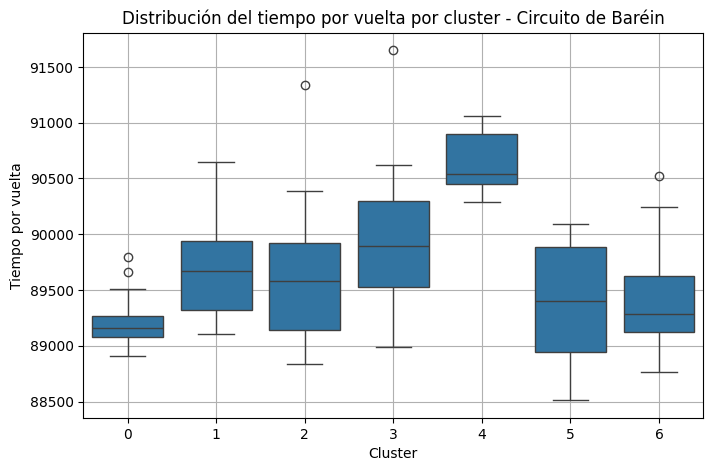

🏁 El cluster más rápido en Baréin es el #0 con tiempo medio de 89225.308 s

🔧 Reglaje promedio del mejor cluster:


,0
m_frontWing,34.00
m_rearWing,30.00
m_onThrottle,40.00
m_offThrottle,50.00
m_frontCamber,-3.20
m_rearCamber,-1.80
m_frontToe,0.09
m_rearToe,0.08
m_frontSuspension,23.00
m_rearSuspension,17.00


In [33]:
best_cluster, best_setup = analyze_cluster_performance(
    cluster_labels=cluster_labels,
    lap_times=lap_times,
    X_original=X_raw,  # sin escalar
    feature_names=X_raw.columns.tolist()
)

## DBSCAN

📊 Resumen por cluster (ordenado por mejor tiempo medio):


,mean,std,count
cluster,,,
0,88966.1,229.606160,10
-1,89599.0,978.635785,2


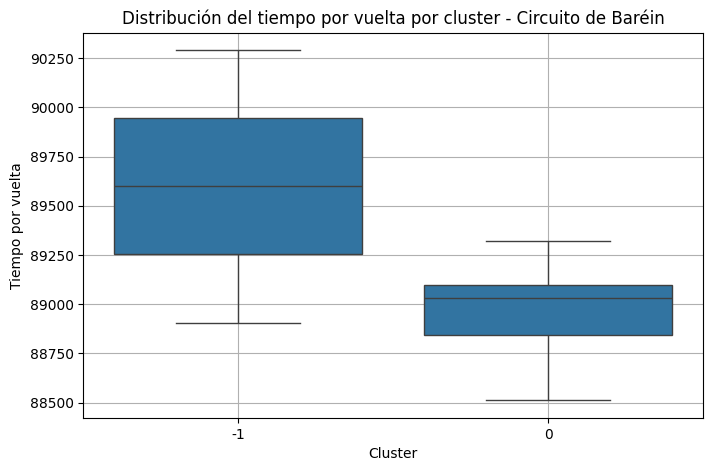

🏁 El cluster más rápido en Baréin es el #0 con tiempo medio de 88966.100 s

🔧 Reglaje promedio del mejor cluster:


,0
m_frontWing,41.300
m_rearWing,36.800
m_onThrottle,69.500
m_offThrottle,54.000
m_frontCamber,-3.470
m_rearCamber,-2.200
m_frontToe,0.135
m_rearToe,0.160
m_frontSuspension,40.000
m_rearSuspension,3.200


In [34]:
best_cluster, best_setup = analyze_cluster_performance(
    cluster_labels=db_labels,
    lap_times=y_unique,
    X_original=X_unique,
    feature_names=X_unique.columns.tolist()
)

## Clusters Lentos Vs Rápidos
Finalmente, miraremos aquellos clusters cuyos centroides tienen un tiempo por vuelta superior o inferior a la media de todos los tiempos.

In [35]:
from scipy.stats import mode
import matplotlib.pyplot as plt
import numpy as np

def plot_fast_vs_slow_clusters(centroids_df, lap_times, title_suffix="K-Means", reference="mean"):
    """
    Dibuja un gráfico de barras para comparar tiempos medios de clusters contra la media o moda global.

    Parámetros:
    - centroids_df: DataFrame con columna 'cluster' y 'lapTime'
    - lap_times: Serie o array con todos los tiempos por vuelta
    - title_suffix: "K-Means" o "DBSCAN"
    - reference: 'mean' o 'mode' (define con qué se comparan los centroides)
    """
    # Selección de umbral de comparación
    if reference == "mean":
      ref_value = lap_times.mean()
      ref_label = f"Media global: {ref_value:.0f} ms"
    elif reference == "median":
      ref_value = np.median(lap_times)
      ref_label = f"Mediana global: {ref_value:.0f} ms"
    elif reference == "mode":
      ref_result = mode(lap_times, keepdims=True)  # <-- importante porque sino se devuelve un escalar en vez de un array
      ref_value = ref_result.mode[0]
      ref_label = f"Moda global: {ref_value:.0f} ms"
    else:
        raise ValueError("Parámetro 'reference' debe ser 'mean' o 'mode'.")

    # Gráfico
    plt.figure(figsize=(8, 6))
    plt.bar(centroids_df["cluster"], centroids_df["lapTime"], color='skyblue', edgecolor='black')

    # Línea horizontal de referencia
    plt.axhline(ref_value, color='red', linestyle='--', label=ref_label)

    # Anotaciones: "Rápido"/"Lento" con respecto al umbral
    for idx, row in centroids_df.iterrows():
        label = "Rápido" if row["lapTime"] < ref_value else "Lento"
        plt.text(row["cluster"], row["lapTime"] + 100, label, ha='center', fontsize=9)

    # Ajuste eje Y
    min_lap = centroids_df["lapTime"].min()
    max_lap = centroids_df["lapTime"].max()
    delta = max_lap - min_lap
    margin = delta * 0.25
    plt.ylim(min_lap - margin, max_lap + margin)

    # Título y estilo
    plt.title(f"Comparación de Clusters: Rápidos vs Lentos ({title_suffix}, ref: {reference}) - Circuito de Baréin")
    plt.xlabel("Cluster")
    plt.ylabel("Tiempo medio por vuelta (ms)")
    plt.legend()
    plt.grid(True)
    plt.show()

## K-means

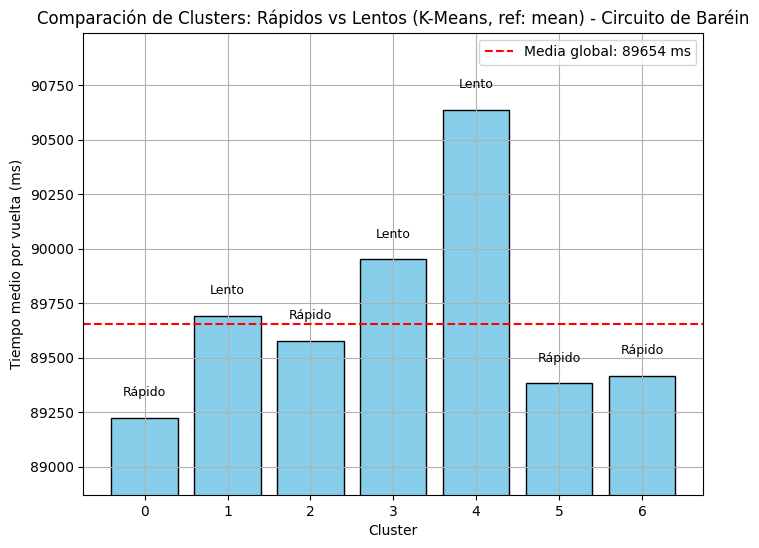

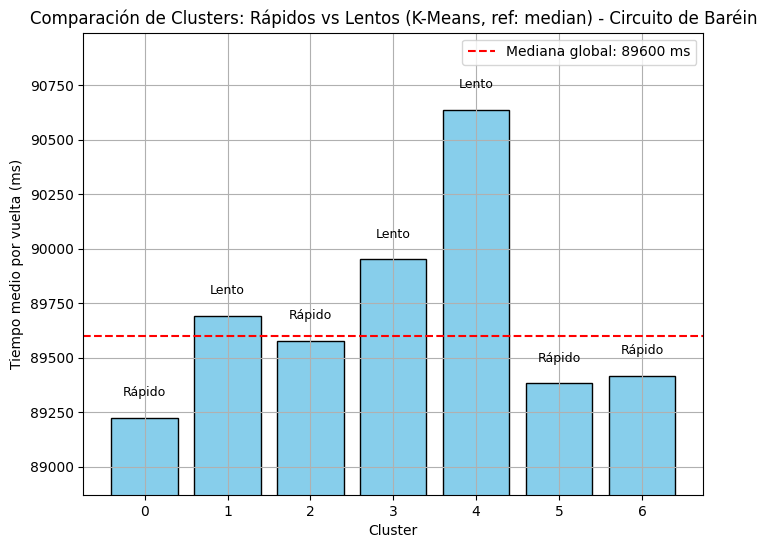

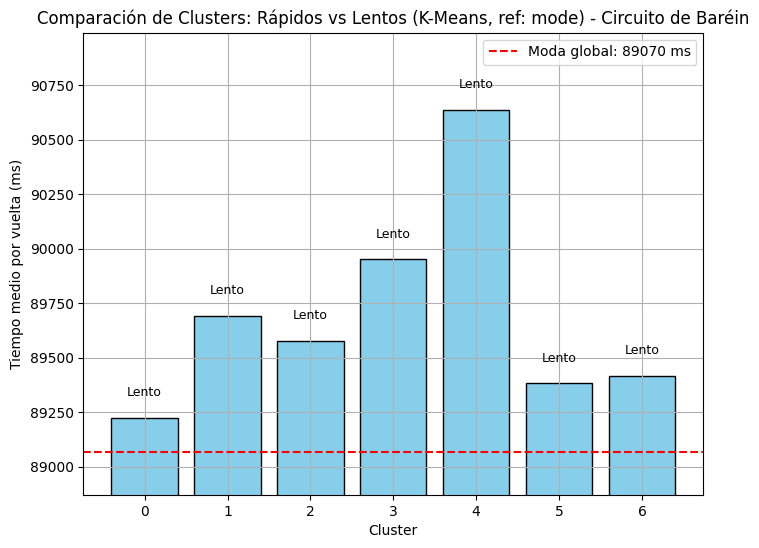

In [36]:
plot_fast_vs_slow_clusters(centroids_df, lap_times, title_suffix="K-Means", reference="mean")
plot_fast_vs_slow_clusters(centroids_df, lap_times, title_suffix="K-Means", reference="median")
plot_fast_vs_slow_clusters(centroids_df, lap_times, title_suffix="K-Means", reference="mode")

## DBSCAN

<ipython-input-35-2817509315>:46: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.



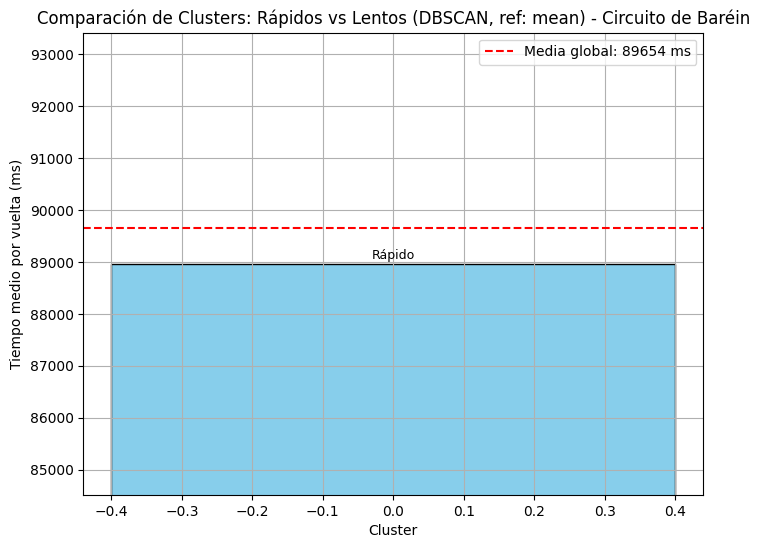

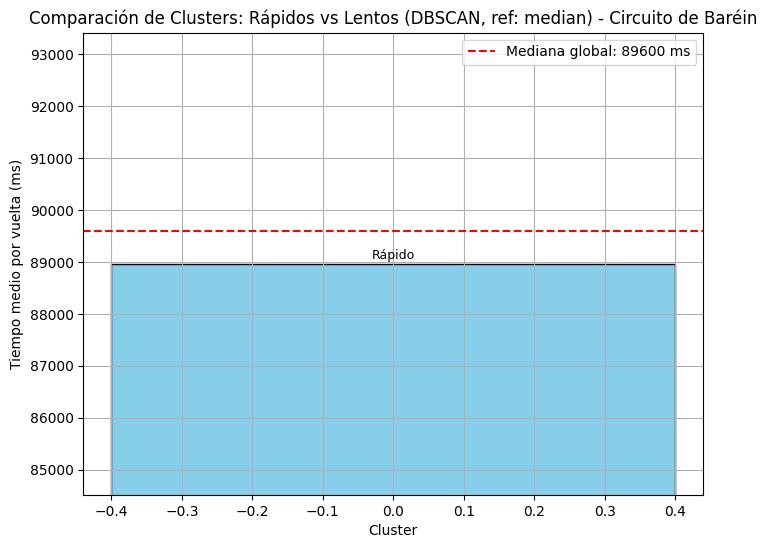

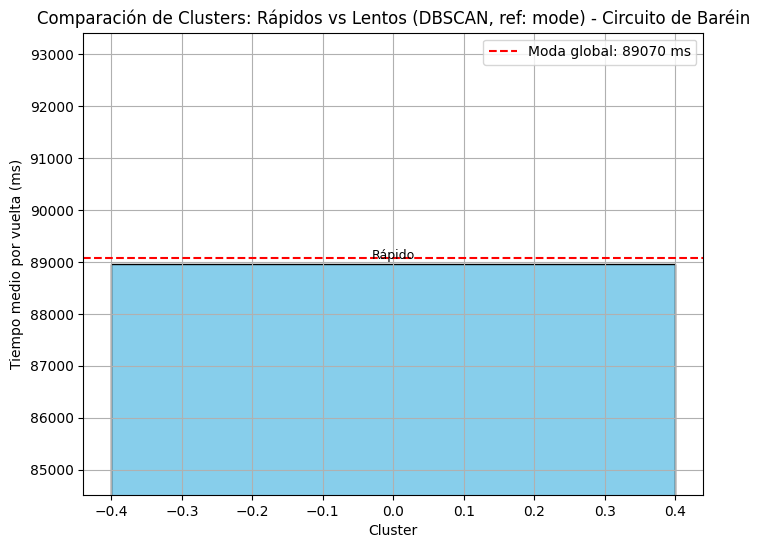

In [37]:
plot_fast_vs_slow_clusters(db_centroids_df, lap_times, title_suffix="DBSCAN", reference="mean")
plot_fast_vs_slow_clusters(db_centroids_df, lap_times, title_suffix="DBSCAN", reference="median")
plot_fast_vs_slow_clusters(db_centroids_df, lap_times, title_suffix="DBSCAN", reference="mode")